Задание 3. LogReg.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from itertools import combinations
import math

np.random.seed(42)

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

[1] Используя функцию make
blobs с любым random
_
_
state, сгенерировать датасет df, в
котором есть три класса с размером каждого класса 100 объектов и восемь
количественных (недискретных) признаков, при этом центры классов зафиксированы в
следующих точках: Класс 0 – (+1,+1,+1,+1,+1,+1,+1,+1), Класс 1 – (-1,-1,-1,-1,
-1,-1,-1,-1),
Класс 2 – (+1,-1,+1,
-1,+1,-1,+1,
-1).
Не забываем повторять шаги задания 1:
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

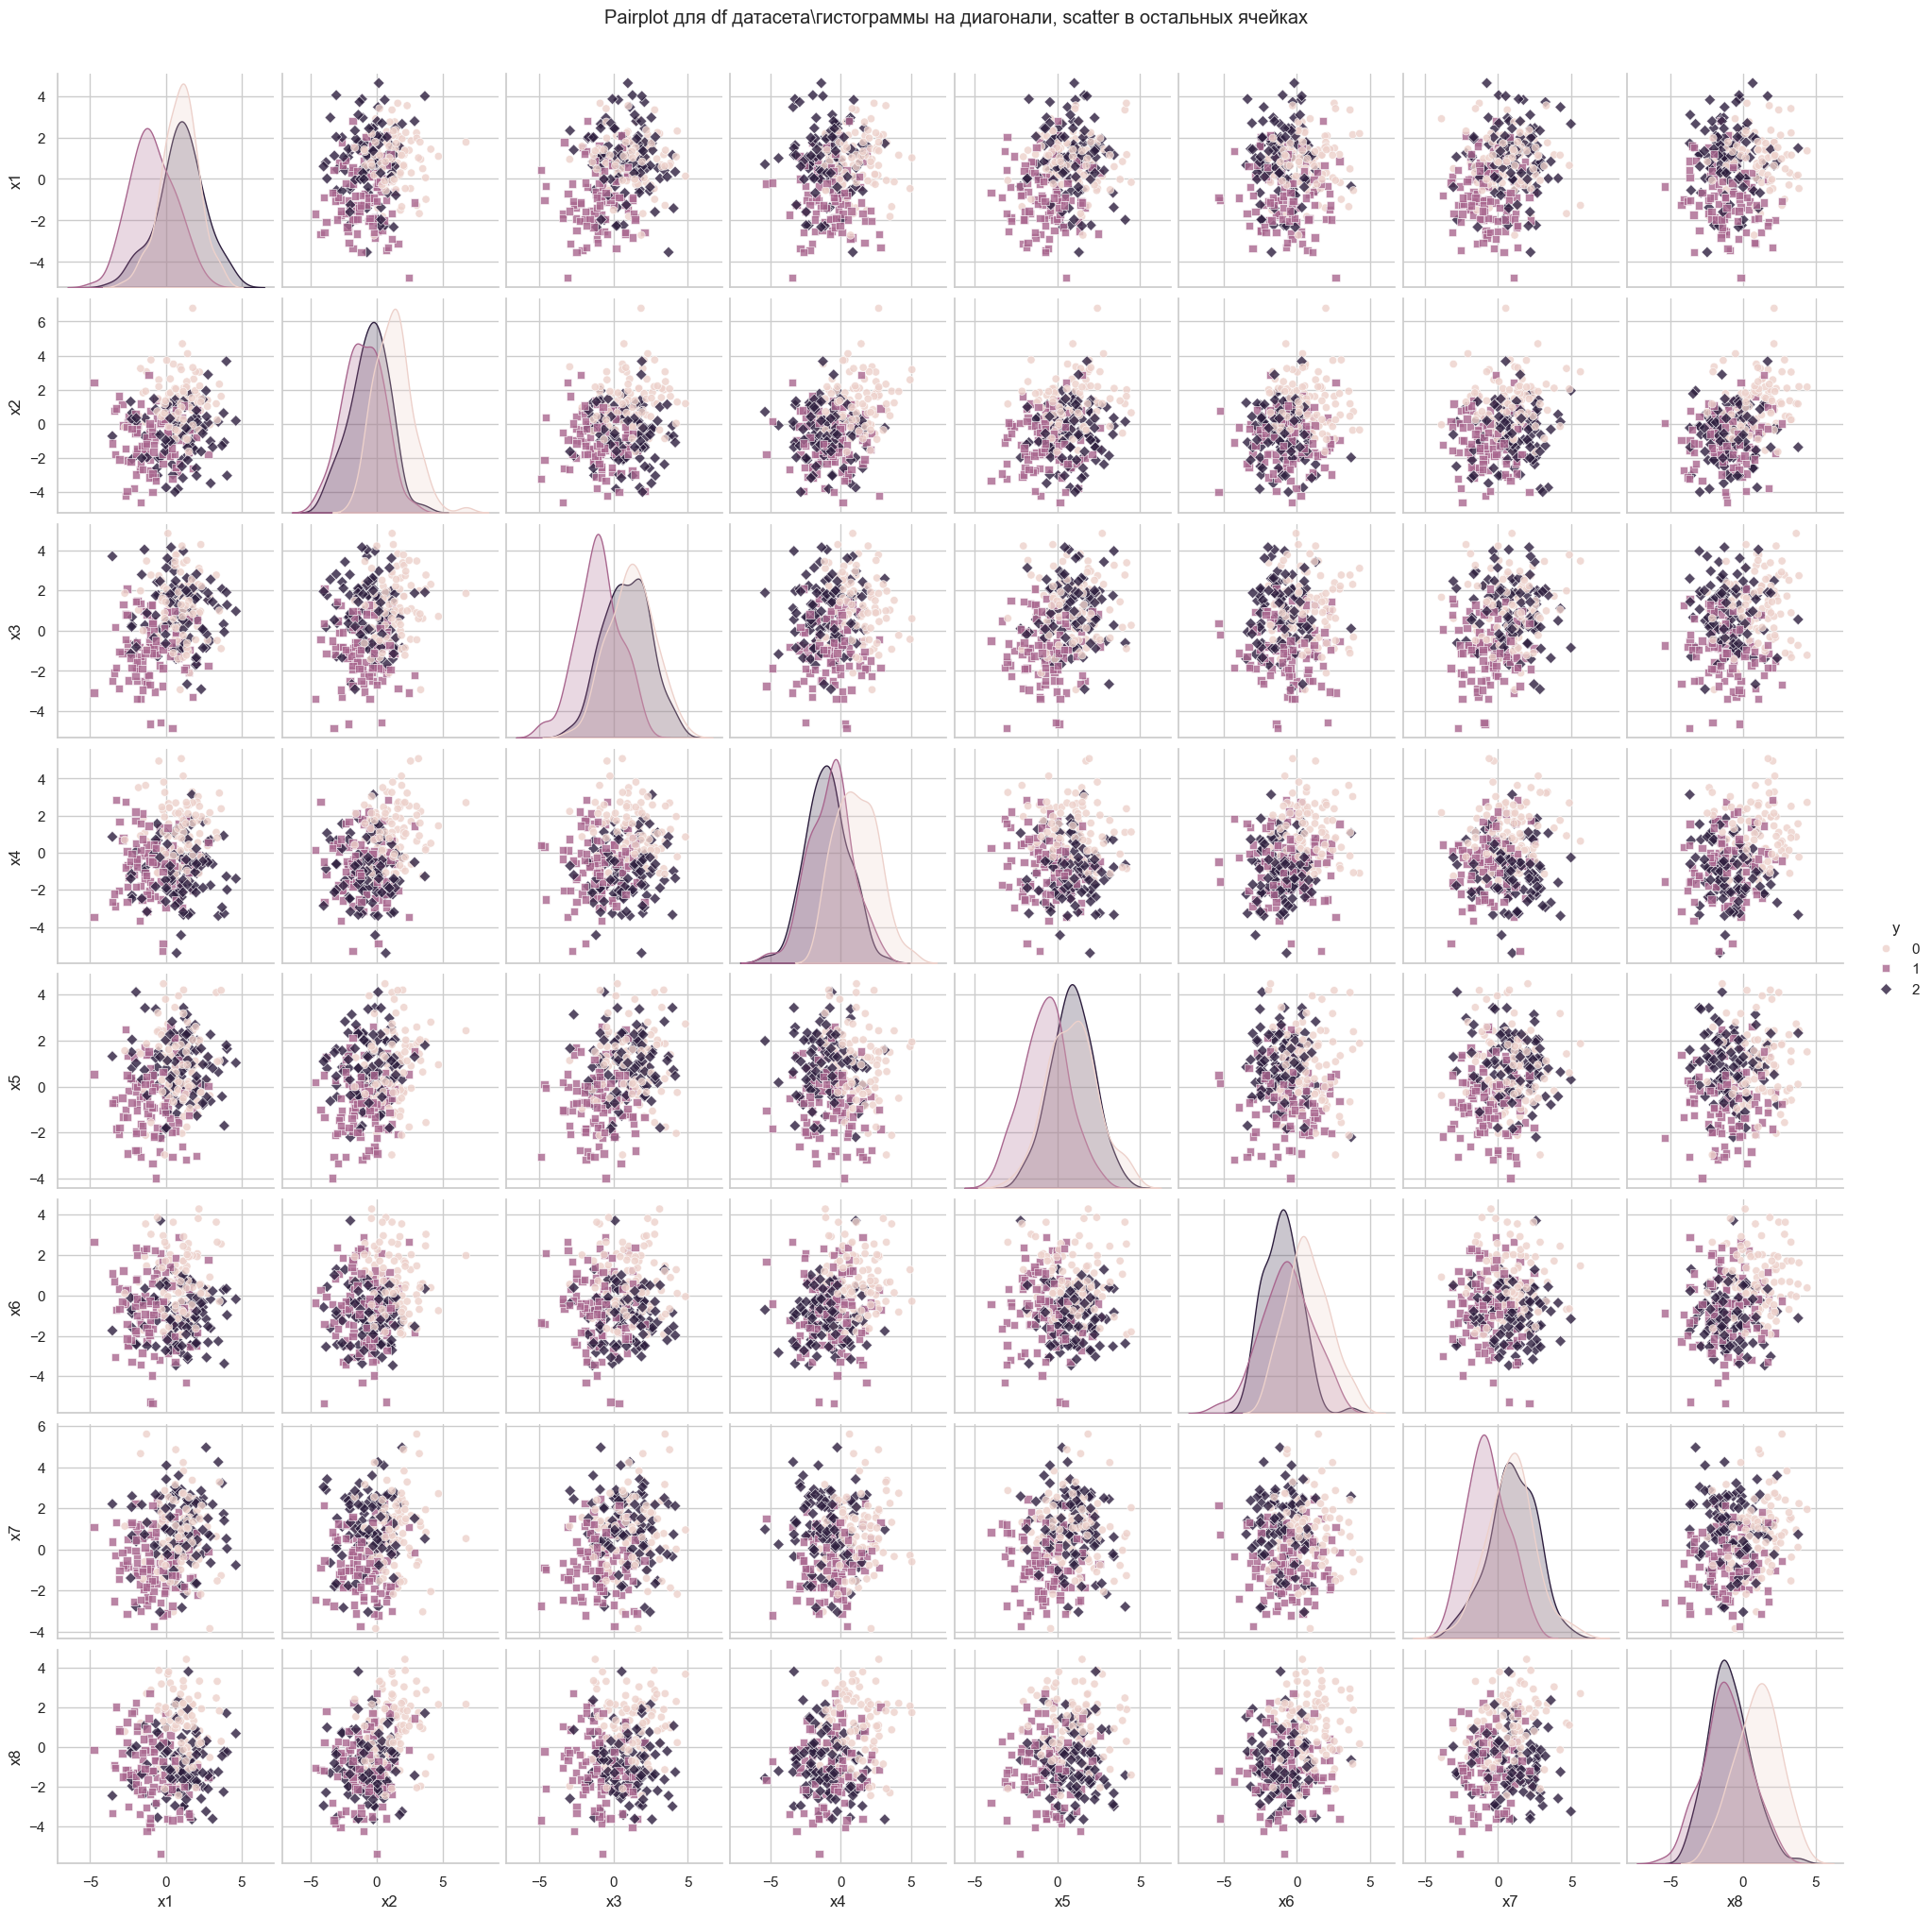

In [37]:
# устанавливаем центры
center0 = np.array([+1]*8)
center1 = np.array([-1]*8)
center2 = np.array([+1,-1,+1,-1,+1,-1,+1,-1])
centers = np.vstack([center0, center1, center2])

# генерируем при помощи make_blobs. std=1.5 чтобы классы перекрывались
X, y = make_blobs(n_samples=300, centers=centers, cluster_std=1.5, random_state=42)

# положим в DataFrame
cols = [f"x{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=cols)
df['y'] = y


sns.pairplot(
    df,
    vars=cols,
    hue="y",       # цвет по классу
    markers=["o", "s", "D"], # разные формы: кружок квадрат ромб
    diag_kind="kde",        # диагональ = гистограммы
    # diag_kws={"bins": 20, "alpha": 0.7}, # 20 разбиений полупрозрачные
    plot_kws={"alpha": 0.8}  # прозрачность точек
)

plt.suptitle("Pairplot для df датасета\гистограммы на диагонали, scatter в остальных ячейках", y=1.02)
plt.show()

Как и ожидалось блака точек для каждого из классов скнцентрированны во круг заданных центров

In [38]:
df.describe()

x1          x2          x3          x4          x5          x6  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.321609   -0.113928    0.348104   -0.211609    0.366134   -0.334505   
std      1.651166    1.760172    1.772458    1.772869    1.568874    1.673336   
min     -4.749109   -4.635819   -4.830882   -5.410583   -3.990603   -5.344383   
25%     -0.829634   -1.319500   -0.890517   -1.427043   -0.663696   -1.480290   
50%      0.519285   -0.125117    0.358255   -0.330365    0.302714   -0.369621   
75%      1.437042    1.106381    1.670962    0.917848    1.427962    0.680258   
max      4.618923    6.779097    4.840127    5.080254    4.471988    4.285683   

               x7          x8           y  
count  300.000000  300.000000  300.000000  
mean     0.360121   -0.357724    1.000000  
std      1.721269    1.782410    0.817861  
min     -3.861901   -5.382026    0.000000  
25%     -0.883821   -1.581182    0.000000  
50%      0.417940   -0.450044    1.000000  
75%      1.500785    0.917898    2.000000  
max      5.618321    4.406039    2.000000

<Axes: >

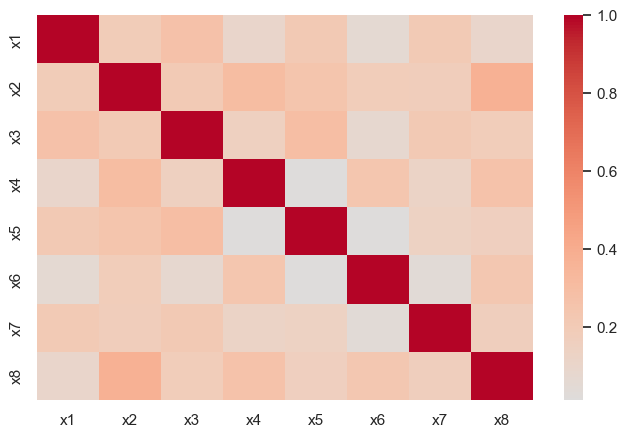

In [39]:
sns.heatmap(df[cols].corr(), cmap='coolwarm', center=0)

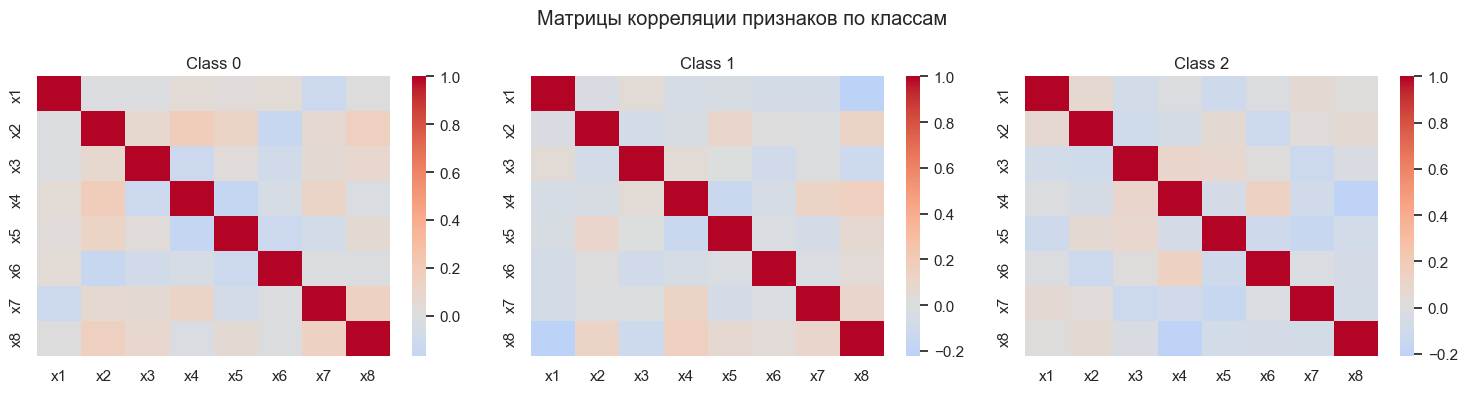

In [40]:
# Матрицы корреляций по каждому классу
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, cls in enumerate(sorted(df['y'].unique())):
    corr_cls = df[df['y'] == cls][cols].corr()
    sns.heatmap(corr_cls, cmap='coolwarm', center=0, ax=axes[i])
    axes[i].set_title(f'Class {cls}')
plt.suptitle('Матрицы корреляции признаков по классам')
plt.tight_layout()
plt.show()

make_blobs генерирует выборки симметричные вокруг заданных центров
Поэтому:
	•	Признаки внутри каждого класса независимы.
	•	Ковариационная матрица внутри каждого кластера - диагональная.
	•	Все признаки имеют одинаковое стандартное отклонение и не коррелируют между собой.

Поэтому корреляции между разными признаками ~= 0  а на диагонали стоят 1.0.
Это одинаково для всех 3 классов, потому что make_blobs не задает различий в дисперсии между кластерами.

[2] На основе созданного в пункте [1] датасета df сгенерировать отдельные
дополнительные датасеты (df_A_B), в которых к классу 0 добавлено A одинаковых точек
с координатами (-B,
+B,-B,+B,
-B,+B,-B,+B), где A = 1, 10, 100 и B = 1, 10, 100, при этом
количество объектов в остальных классах неизменно.

In [41]:
# К классу 0 добавляются A одинаковых точек с координатами (-B,+B,-B,+B,-B,+B,-B,+B)
# A = {1, 10, 100} B = {1, 10, 100}. Для каждого сочетания формируем отдельный датасет
As = [1,10,100]
Bs = [1,10,100]

datasets = {}  # словарь: название -> DataFrame
# базовый оригинальный датасет
datasets['df'] = df.copy()

for A in As:
    for B in Bs:
        key = f'df_{A}_{B}'
        base = df.copy()
        added_point = np.array([-B, +B, -B, +B, -B, +B, -B, +B])
        added = np.tile(added_point, (A,1))
        added_df = pd.DataFrame(added, columns=cols)
        added_df['y'] = 0  # класс 0
        newdf = pd.concat([base, added_df], ignore_index=True)
        datasets[key] = newdf

print('Сформированы датасеты:')
for k in list(datasets.keys()):
    print(k, datasets[k].shape)

Сформированы датасеты:
df (300, 9)
df_1_1 (301, 9)
df_1_10 (301, 9)
df_1_100 (301, 9)
df_10_1 (310, 9)
df_10_10 (310, 9)
df_10_100 (310, 9)
df_100_1 (400, 9)
df_100_10 (400, 9)
df_100_100 (400, 9)


[3] Выбрать пару классов 0 и 1, и один количественный признак.
Для каждого из датасетов из списка (df, df_A_B) в своем пространстве Х-Y
(количественный признак-класс) построить и визуализировать объекты, линию линейной
регрессии и линию логистической регрессии. Регрессии строить на паре Х-Y(
количественный признак-класс).
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые, восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
оценные бутстрепом доверительные интервалы CI95 (n=1000).
Все полученные графики возможно расположить в две колонки: левая колонка –
визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.

Выберем пару классов 0 vs 1 и один признак x1.
Для каждого датасета (df, df_A_B) построим:
- scatter plot (X vs Y), линию регрессии
- линию логистической регрессии (probability vs X)
- ROC-кривая с отметкой порога 0.5, bootstrap CI для sens / spec

In [42]:
feature = 'x1'
class_pair = (0,1)
bootstrap_n = 1000

def prepare_binary(df, pair=class_pair):
    # Возвращает X вещественный признак и y_bin = 0 / 1 для выбранных классов
    sub = df[df['y'].isin(pair)].copy()
    sub = sub.reset_index(drop=True)
    X = sub[[feature]].values
    y_bin = (sub['y'] == pair[1]).astype(int).values

    return X, y_bin, sub


def fit_linear(X, y):
    lr = LinearRegression()
    lr.fit(X, y)

    return lr


def fit_logistic(X, y):
    clf = LogisticRegression(solver='liblinear')
    clf.fit(X, y)

    return clf


def roc_and_auc(clf, X, y):
    probs = clf.predict_proba(X)[:,1]
    fpr, tpr, thr = roc_curve(y, probs)

    return fpr, tpr, thr, probs


def sensitivity_specificity_at_threshold(y_true, probs, thr=0.5):
    y_pred = (probs >= thr).astype(int)
    tp = np.sum((y_true==1) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))
    sens = tp / (tp+fn) if (tp+fn)>0 else np.nan
    spec = tn / (tn+fp) if (tn+fp)>0 else np.nan

    return sens, spec


def bootstrap_roc_ci(model, X, y, n_bootstraps=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    boot_tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(X), len(X))
        X_boot = X[indices]
        y_boot = y[indices]
        model.fit(X_boot, y_boot)
        proba = model.predict_proba(X_boot)[:, 1]
        fpr, tpr, _ = roc_curve(y_boot, proba)
        boot_tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    boot_tprs = np.array(boot_tprs)
    mean_tpr = boot_tprs.mean(axis=0)
    ci_lower = np.percentile(boot_tprs, 2.5, axis=0)
    ci_upper = np.percentile(boot_tprs, 97.5, axis=0)
    return mean_fpr, mean_tpr, ci_lower, ci_upper


def bootstrap_ci_sens_spec(y_true, probs, thr=0.5, n_boot=1000, seed=42):
    rng = np.random.RandomState(seed)
    sens_list = []
    spec_list = []
    N = len(y_true)
    for i in range(n_boot):
        idx = rng.choice(N, size=N, replace=True)
        sens, spec = sensitivity_specificity_at_threshold(y_true[idx], probs[idx], thr)
        sens_list.append(sens)
        spec_list.append(spec)

    # 95% CI
    sens_ci = np.percentile(sens_list, [2.5,97.5])
    spec_ci = np.percentile(spec_list, [2.5,97.5])
    
    return sens_ci, spec_ci

def plot_feature_analysis(df_dict, feature=feature, pair=class_pair, bootstrap_n=1000):
    n = len(df_dict)
    ncols = 2
    nrows = n
    fig = plt.figure(figsize=(10, 4*nrows))
    gs = fig.add_gridspec(nrows, ncols, wspace=0.3, hspace=0.5)

    row = 0
    for key, D in df_dict.items():
        X, y_bin, sub = prepare_binary(D, pair)
        # обучаем модельки для каждого датасета
        lr = fit_linear(X, y_bin)
        clf = fit_logistic(X, y_bin)

        fpr, tpr, thr, probs = roc_and_auc(clf, X, y_bin)
        auc_val = auc(fpr, tpr)
        sens, spec = sensitivity_specificity_at_threshold(y_bin, probs, thr=0.5)
        sens_ci, spec_ci = bootstrap_ci_sens_spec(y_bin, probs, thr=0.5, n_boot=bootstrap_n)
        mean_fpr, mean_tpr, ci_lower, ci_upper = bootstrap_roc_ci(clf, X, y_bin)

        # левый: scatter + лин рег + logistic curve
        ax1 = fig.add_subplot(gs[row, 0])
        # scatter
        ax1.scatter(sub[feature], y_bin, c=sub['y'], cmap='coolwarm', s=20, alpha=0.7)
        # линия лин рега
        xs = np.linspace(sub[feature].min()-0.5, sub[feature].max()+0.5, 200).reshape(-1,1)
        ys_lin = lr.predict(xs)
        ax1.plot(xs, ys_lin, label='LinReg', linewidth=2)
        # logistic prob curve
        ys_log = clf.predict_proba(xs)[:,1]
        ax1.plot(xs, ys_log, label='LogReg', linewidth=2)
        ax1.set_ylim(-0.1,1.1)
        ax1.set_title(f'{key}: {feature} vs class ({pair[0]} vs {pair[1]})')
        ax1.set_xlabel(feature)
        ax1.set_ylabel('target (0/1)')
        ax1.legend()

        # правый: ROC
        ax2 = fig.add_subplot(gs[row, 1])
        ax2.plot(fpr, tpr, label=f'ROC (AUC={auc_val:.3f})')
        plt.fill_between(mean_fpr, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
        ax2.plot([0,1],[0,1],'k--', alpha=0.4)
        ax2.set_title('ROC и точка классификации (thr=0.5)')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        # точка
        ax2.scatter(1-spec, sens, c='red', label=f'Точка (sens={sens:.3f}, spec={spec:.3f})')
        # CI
        ax2.errorbar(1-spec, sens, xerr=[[1-spec - (1-spec_ci[1])],[ (1-spec_ci[0]) - (1-spec)]],
                     yerr=[[sens - sens_ci[0]],[sens_ci[1]-sens]], fmt='o', color='red', alpha=0.6)
        ax2.legend()

        row += 1

    plt.suptitle(f'Анализ признака {feature} для пары классов {pair[0]} vs {pair[1]}')
    plt.show()

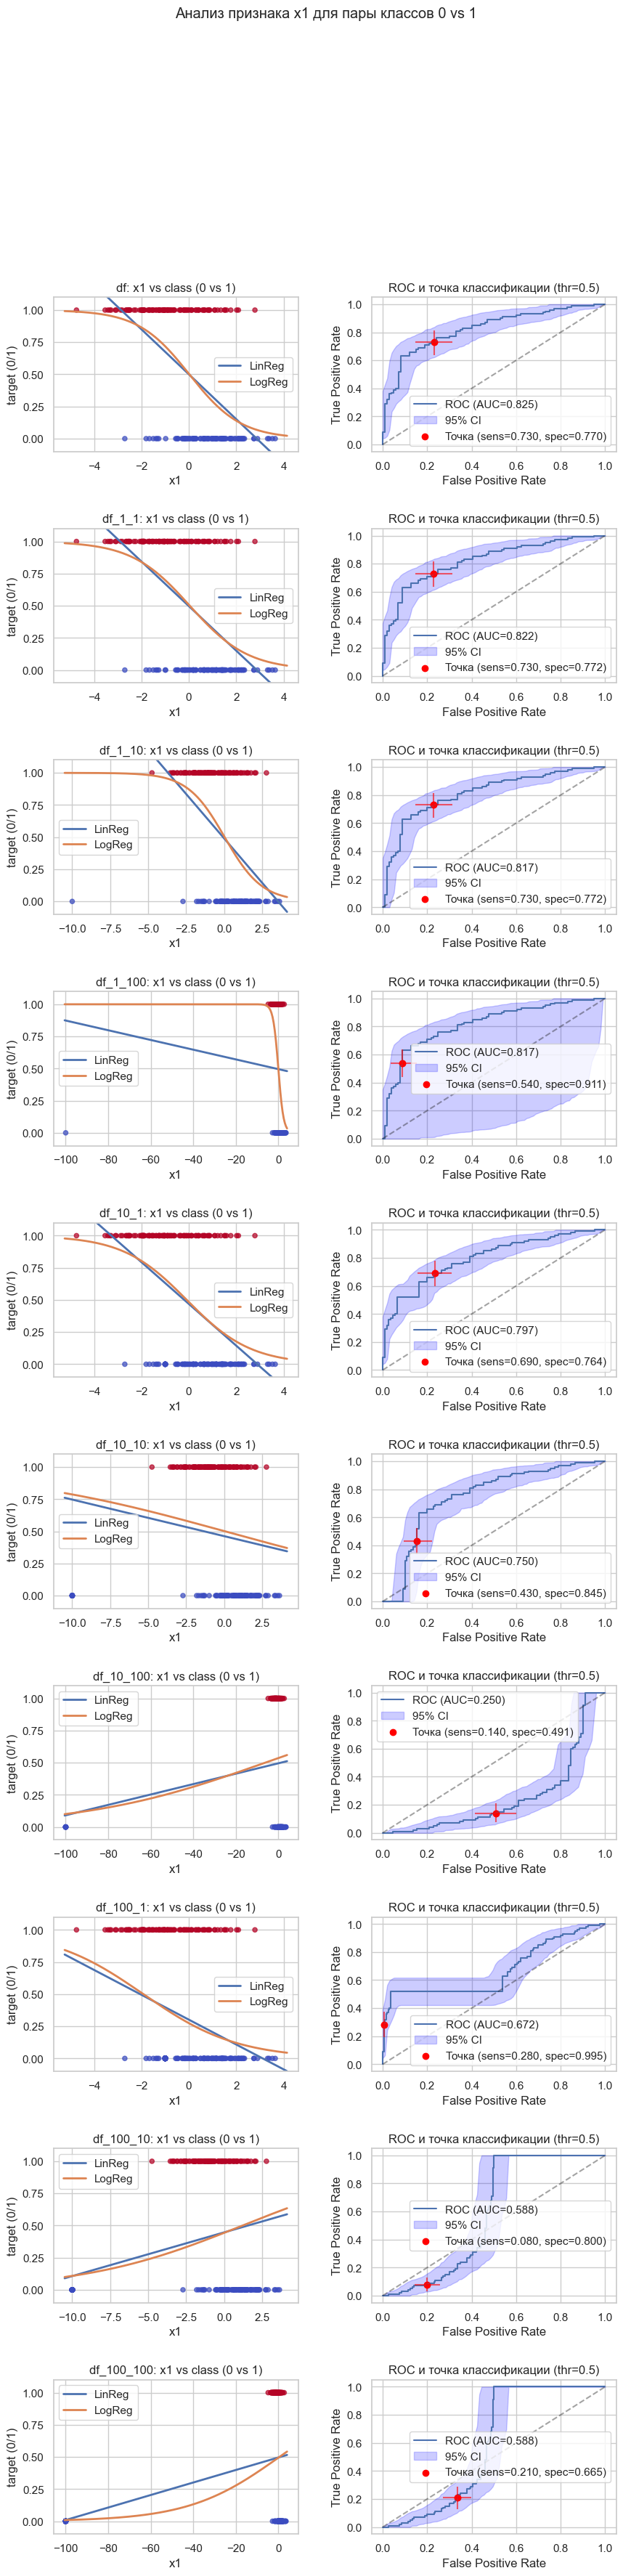

In [43]:
# Вызовем функцию для всех датасетов включая оригинальный df.
# по требованию n=1000 - при выполнении займет много времени.

# собрать словарь все 9 вариантов + df
sel_keys = ['df'] + [f'df_{A}_{B}' for A in As for B in Bs]
sel = {k: datasets[k] for k in sel_keys}

plot_feature_analysis(sel, feature=feature, pair=class_pair, bootstrap_n=1000)

* Линия линейной регрессии:
    * просто аппроксимация Y = a + bX.
    * может давать значения >1 или <0 тк не является вероятностью.
    * показывает тенденцию - растет ли вероятность принадлежности к классу 1 при росте признака X.
* Линия логистической регрессии:
    * сигмоида.
    * интерпретируется как вероятность принадлежности к классу 1.
    * где P(Y=1|X)=0.5 - граница классификации (treshhold).

Параметры A и B искусственно добавляют точки в класс 0:
* При небольших A и B модель почти не меняется, а при больших - появляется сильный перекос:
    * лин рег - смещается усредняя все точки;
    * лог рег - порог 0.5 сдвигается и кривая деформируется;
    * доверительные интервалы расширяются тк модель менее стабильна.

сигмоида переворачивается тк:
* Логистическая регрессия подбирает вектор весов w и сдвиг b, чтобы $P(Y=1|X) = \frac{1}{1 + e^{-(wX + b)}}$
* Когда появляются далекие выбросы с огромным по модулю X но принадлежащие классу 0 модель пытается объяснить их как P(Y=1|X) ~= 0.
* Чтобы это получилось она вынуждена поменять знак коэффициента w:
	* раньше - при увеличении X вероятность класса 1 растет ;
	* теперь - при увеличении X вероятность должна падать (вес становится отрицательным).
* В итоге сигмоида переворачивается вертикально (на графике идет сверху вниз).

ROC-кривая падает ниже baseline тк:
* ROC-кривая строится по отсортированным значениям вероятностей класса 1.
* Если модель перепутала направление то:
	* высоким значениям P(Y=1|X) на самом деле соответствуют объекты класса 0, а низким - объекты класса 1.
* Следовательно:
	* True Positive Rate становится низким,
	* False Positive Rate становится высоким.
 	* кривая опускается ниже baseline.

Геометрически это значит модель делает все наоборот: там, где должна видеть класс 1, видит класс 0.

[4] Для выбранной пары классов (включая класс с повторенными объектами) на первых
четырех признаках вычислить уравнение множественной линейной регрессии, где Xi –
признаки.
Используя полученное уравнение множественной линейной регрессии, на основе
каждого из датасетов из списка (df, df_A_B) сформировать новые датасеты logdf,
logdf_A_B, в каждом из которых есть только один признак Х, сформированный на основе
соответствующего уравнения множественной линейной регрессии, а переменная Y –
определяет отнесение к классу.

Для выбранной пары классов 0 и 1 обучаем множественную линейную регрессию где Xi - первые 4 признака а целевая переменная y - класс 0 или 1. Затем по формуле получаем новый признак Х - линейная комбинация (предсказание модели). 


In [44]:
multi_models = {}
logdfs = {}

for key, D in sel.items():
    sub = D[D['y'].isin(class_pair)].copy().reset_index(drop=True)
    X_multi = sub[[ 'x1','x2','x3','x4']].values
    y_bin = (sub['y'] == class_pair[1]).astype(int).values

    # БЕЗ ЭТОГО РАЗДЕЛЕНИЯ НА ШАГЕ 5 Я ПОЛУЧИЛ ROC AUC = 1.0 ДЛЯ ВСЕХ СЛУЧАЕВ! ТАК КАК МОДЕЛЬ УЧИТСЯ И ИСПОЛЬЗУЕТСЯ НА ОДНИХ И ТЕХ-ЖЕ ДАННЫХ. С РАЗДЕЛЕНИЕМ ROC AUC ВСЕ РАВНО ОСТАЛСЯ 1.0 НО Я СЧИТАЮ ЧТО ТАК БОЛЕЕ ЧЕСТНО
    X_train, X_test, y_train, y_test = train_test_split(X_multi, y_bin, test_size=0.3, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    multi_models[key] = lr
    # получим предсказание — это будет новый признак
    pred = lr.predict(X_test)
    logdf = pd.DataFrame({'X': pred, 'y': y_test})
    logdfs[key] = logdf
    print(f'{key}: coeffs={lr.coef_}, intercept={lr.intercept_}')


df: coeffs=[-0.06797901 -0.06872442 -0.10103614 -0.07428439], intercept=0.49108694471134934
df_1_1: coeffs=[-0.0740228  -0.07193584 -0.09488894 -0.07568973], intercept=0.49779729787047294
df_1_10: coeffs=[-0.06363916 -0.08102494 -0.08571172 -0.08327846], intercept=0.5024469374148445
df_1_100: coeffs=[-0.06666751 -0.07850126 -0.08826389 -0.08120378], intercept=0.503845906292341
df_10_1: coeffs=[-0.06329465 -0.09363173 -0.07818222 -0.0858878 ], intercept=0.5090051506959632
df_10_10: coeffs=[-0.06086073 -0.09562837 -0.07499469 -0.08815221], intercept=0.5337490684687758
df_10_100: coeffs=[-0.07295515 -0.08488024 -0.08618892 -0.07959271], intercept=0.5338488017751674
df_100_1: coeffs=[-0.02921237 -0.15329925 -0.0375158  -0.08899314], intercept=0.3951627232640412
df_100_10: coeffs=[-0.0728831  -0.11578712 -0.06510213 -0.07234708], intercept=0.5086887086353545
df_100_100: coeffs=[-0.08743431 -0.10348882 -0.07476411 -0.06382656], intercept=0.511895261641617


Коэффициеты b в $\hat{y} = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_3 + b_4 x_4$ <br> intercept = b_0 coeffs =[b_1, b_2, b_3, b_4]

[5] Для каждого из датасетов из списка (logdf, logdf_A_B) в своем пространстве Х-Y
(количественный признак-класс) построить и визуализировать объекты, линию простой
линейной регрессии и линию логистической регрессии. Регрессии строить на паре Х-Y
(количественный признак-класс).
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые и восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
доверительные интервалы CI95 бутстрепом (n=1000).
Все полученные графики возможно расположить в две колонки, аналогично пункту [3].

Для каждого log_df построим то же самое. scatter X vs Y, линию простой лин регрессии, линиб лог регрессии, ROC, bootstrap CI.

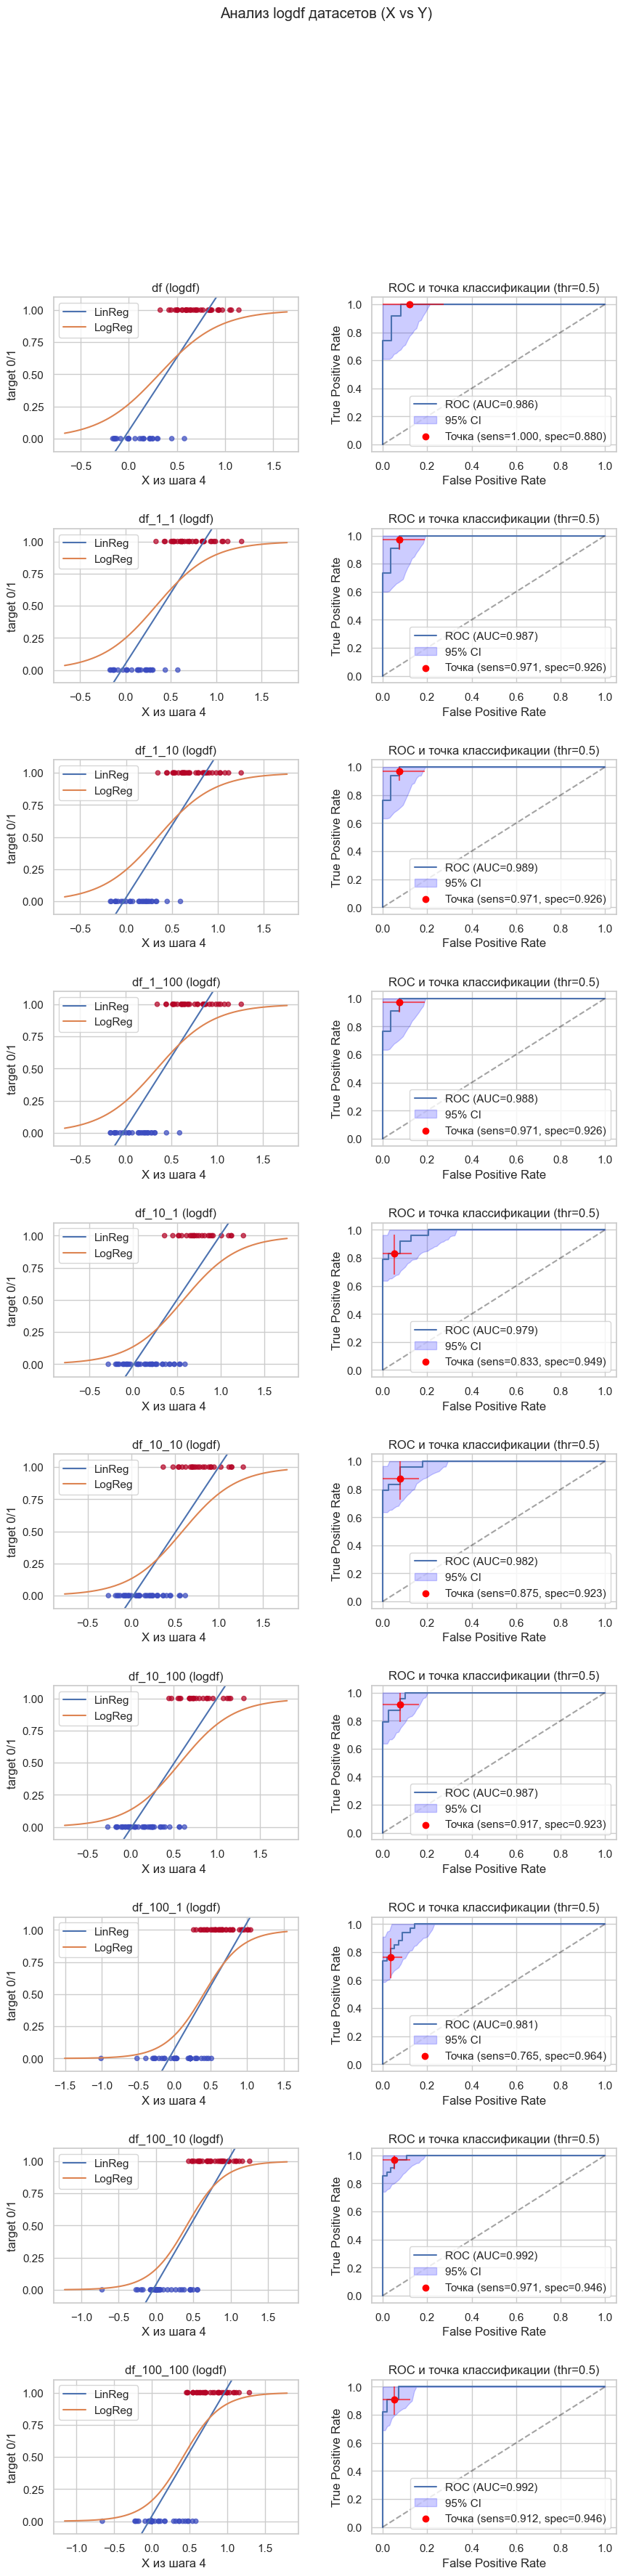

In [45]:
def plot_logdfs(logdfs_dict, bootstrap_n=1000):
    n = len(logdfs_dict)
    ncols = 2
    nrows = n
    fig = plt.figure(figsize=(10, 4*nrows))
    gs = fig.add_gridspec(nrows, ncols, wspace=0.3, hspace=0.5)
    row = 0
    for key, D in logdfs_dict.items():
        X = D[['X']].values
        y = D['y'].values
        # fit
        lin = LinearRegression().fit(X, y)
        clf = LogisticRegression(solver='liblinear').fit(X, y)
        fpr, tpr, thr, probs = roc_and_auc(clf, X, y)
        auc_val = auc(fpr, tpr)
        sens, spec = sensitivity_specificity_at_threshold(y, probs, thr=0.5)
        sens_ci, spec_ci = bootstrap_ci_sens_spec(y, probs, thr=0.5, n_boot=bootstrap_n)
        mean_fpr, mean_tpr, ci_lower, ci_upper = bootstrap_roc_ci(clf, X, y)

        ax1 = fig.add_subplot(gs[row,0])
        ax1.scatter(X.ravel(), y, c=y, cmap='coolwarm', s=20, alpha=0.7)
        xs = np.linspace(X.min()-0.5, X.max()+0.5, 200).reshape(-1,1)
        ax1.plot(xs, lin.predict(xs), label='LinReg')
        ax1.plot(xs, clf.predict_proba(xs)[:,1], label='LogReg')
        ax1.set_ylim(-0.1,1.1)
        ax1.set_title(f'{key} (logdf)')
        ax1.set_xlabel('X из шага 4 ')
        ax1.set_ylabel('target 0/1')
        ax1.legend()

        ax2 = fig.add_subplot(gs[row,1])
        ax2.plot(fpr, tpr, label=f'ROC (AUC={auc_val:.3f})')
        plt.fill_between(mean_fpr, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
        ax2.plot([0,1],[0,1],'k--', alpha=0.4)
        ax2.set_title('ROC и точка классификации (thr=0.5)')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.scatter(1-spec, sens, c='red', label=f'Точка (sens={sens:.3f}, spec={spec:.3f})')
        ax2.errorbar(1-spec, sens, yerr=[[sens - sens_ci[0]],[sens_ci[1]-sens]],
                     xerr=[[1-spec - (1-spec_ci[1])],[ (1-spec_ci[0]) - (1-spec)]], fmt='o', color='red', alpha=0.6)
        ax2.legend()
        row += 1
    plt.suptitle('Анализ logdf датасетов (X vs Y)')
    plt.show()


plot_logdfs(logdfs, bootstrap_n=1000)

[6] Для выбранной пары классов (включая класс с повторенными объектами),
визуализировать один из датасетов df_A_B на всех парах переменных, построив на
графиках объекты, линии множественной линейной регрессии, разделение классов на
основе логистической регрессии решающей функцией с contour_plot уровнями
классификации c подписанной вероятностью отнесения к целевому классу.

Возьмём df_100_100 как наиболее экстремальный набор и построим для каждой пары признаков:
- scatter точки классов, линия множественной лин рег по 2 признакам. здесь мы можем показывать:
    - предсказание регрессии в виде линии / плоскости в 2D при паре признаков. регрессия по двум признакам.
    - Решающая функция для логистической регрессии (вероятность принадлежности к классу 1)

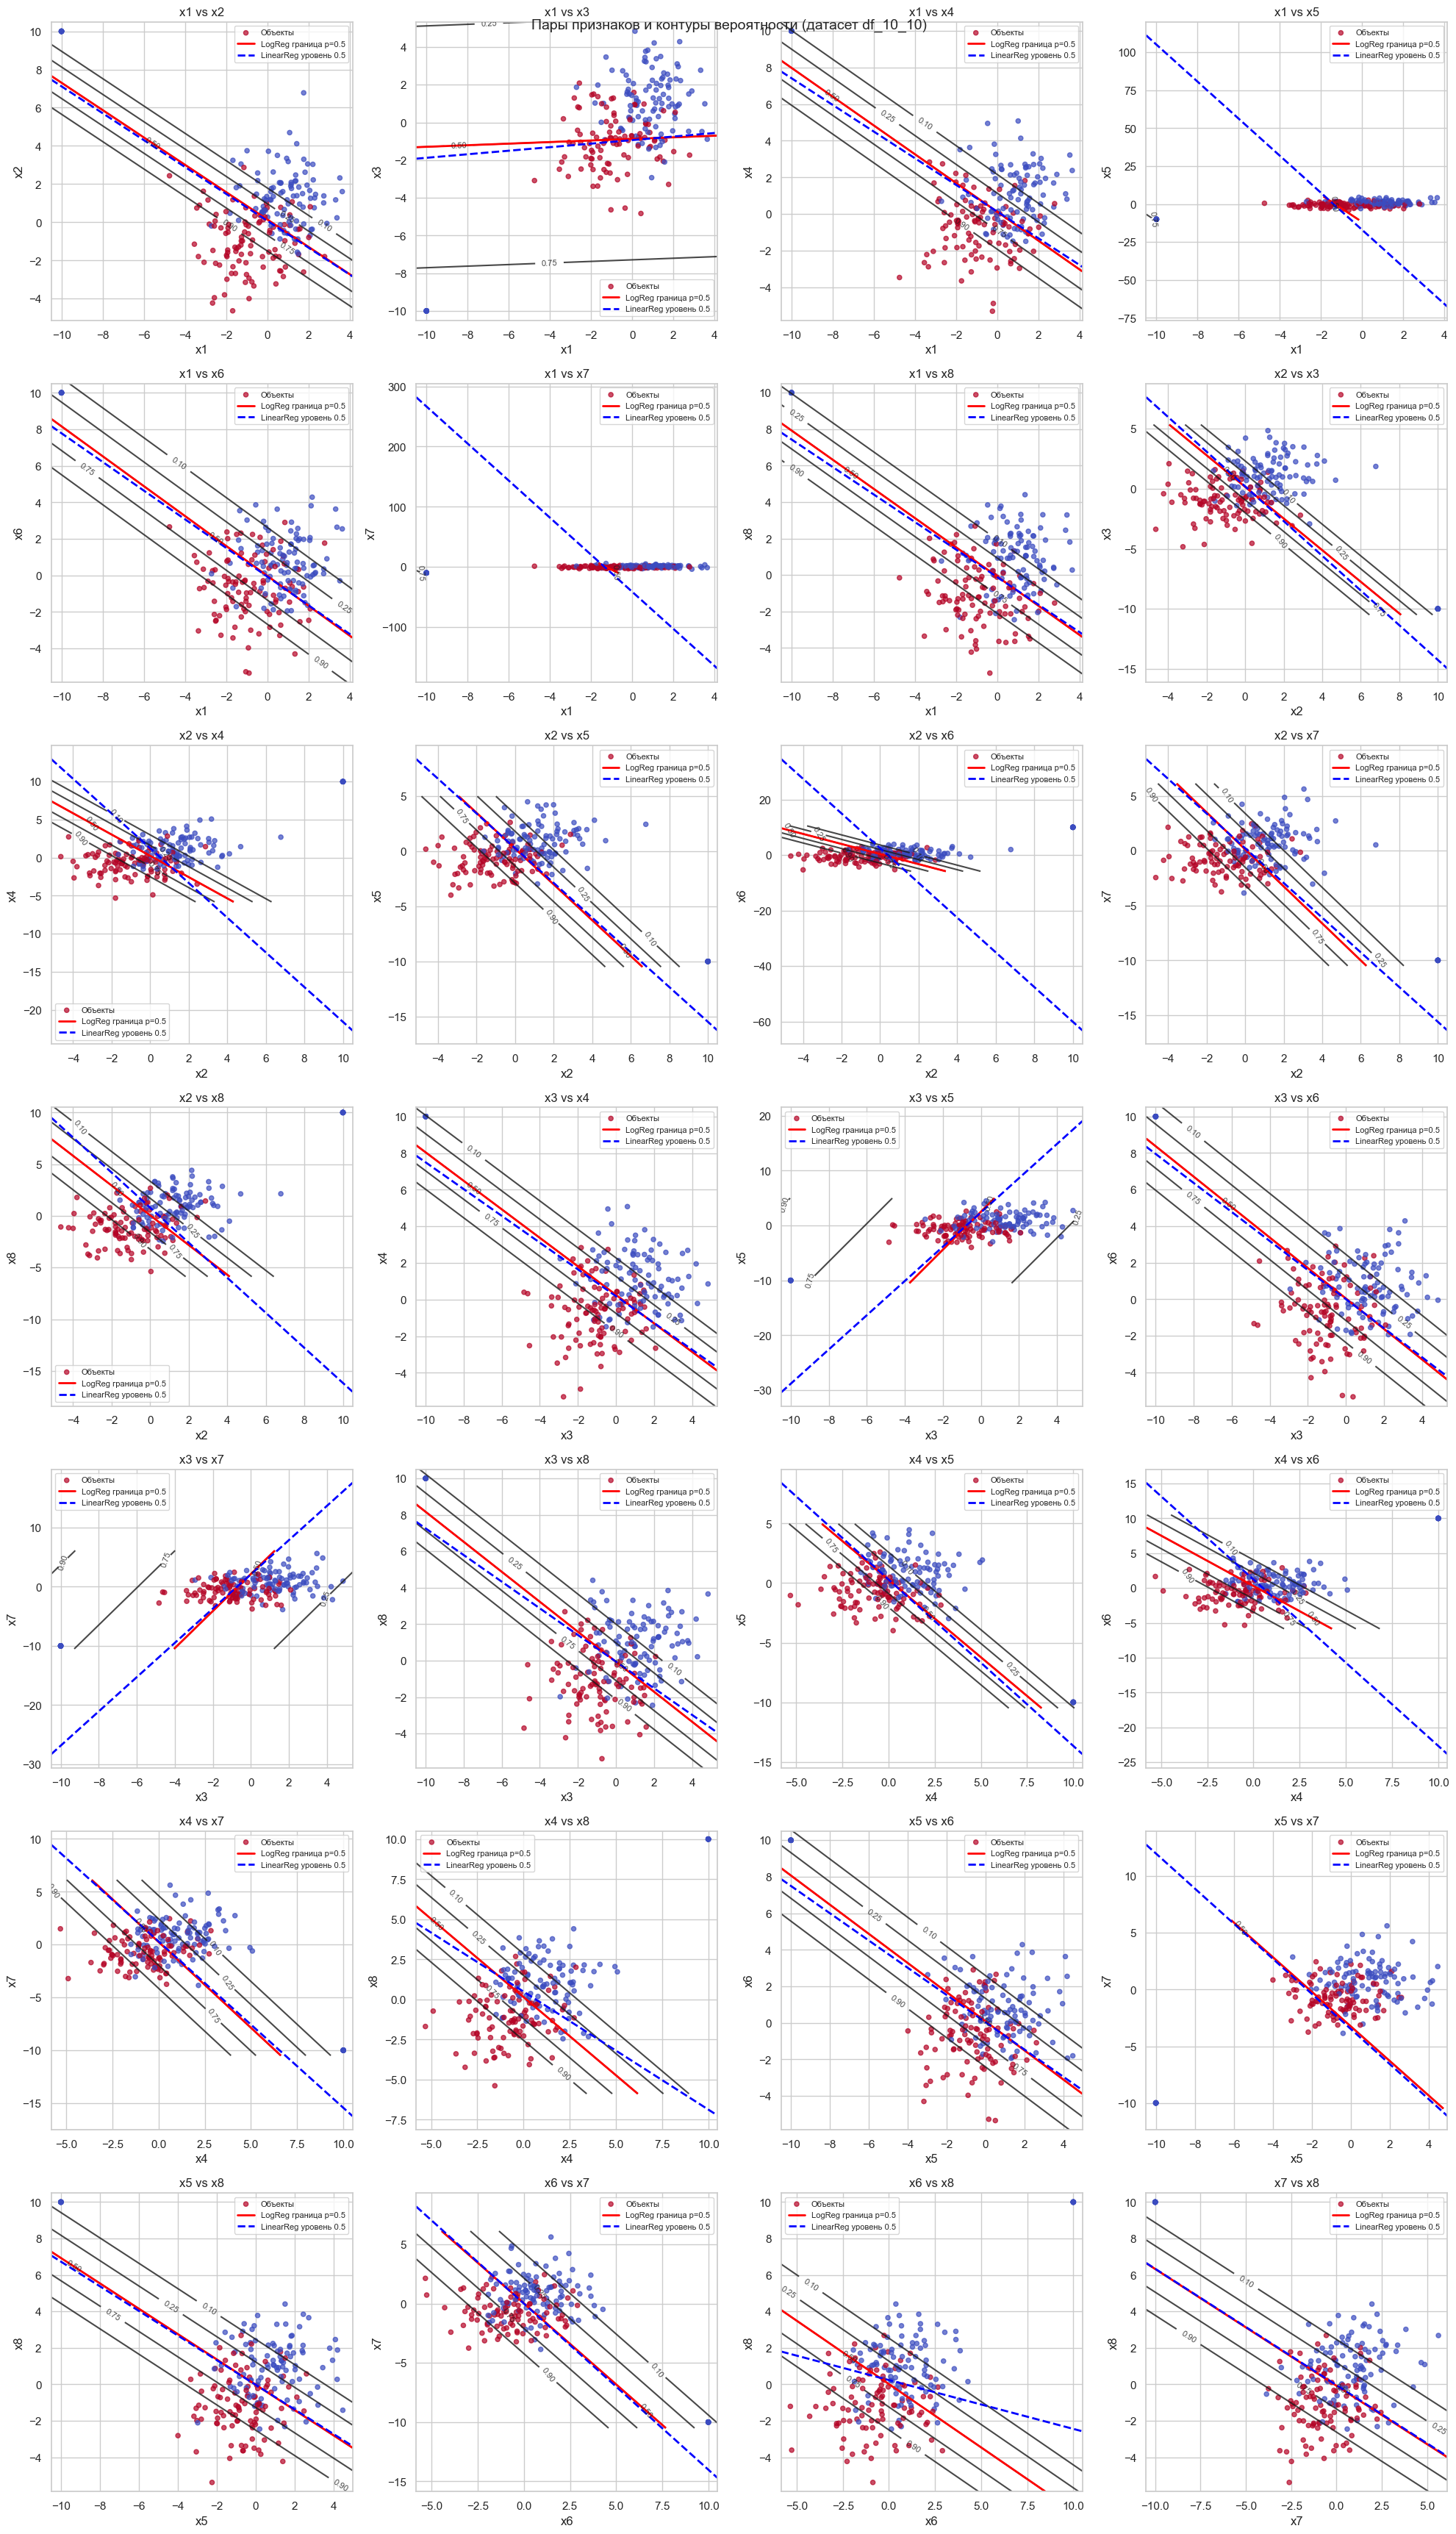

In [46]:
chosen_key = 'df_10_10'
D = datasets[chosen_key]
sub = D[D['y'].isin(class_pair)].copy().reset_index(drop=True)

pairs = list(combinations(cols, 2))

def plot_pair_decision(Dsub, feat1, feat2, ax=None):
    X_pair = Dsub[[feat1, feat2]].values
    y = (Dsub['y'] == class_pair[1]).astype(int).values

    # обучение моделей
    clf2 = LogisticRegression(solver='liblinear')
    clf2.fit(X_pair, y)
    lin2 = LinearRegression().fit(X_pair, y)

    # точки
    ax.scatter(Dsub[feat1], Dsub[feat2], c=y, cmap='coolwarm', s=20, alpha=0.7, label='Объекты')
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_title(f'{feat1} vs {feat2}')

    # сетка и вероятности логистической регрессии
    xx, yy = np.meshgrid(
        np.linspace(Dsub[feat1].min()-0.5, Dsub[feat1].max()+0.5, 200),
        np.linspace(Dsub[feat2].min()-0.5, Dsub[feat2].max()+0.5, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf2.predict_proba(grid)[:, 1].reshape(xx.shape)

    # контуры вероятности
    cs = ax.contour(xx, yy, probs, levels=[0.1, 0.25, 0.5, 0.75, 0.9], alpha=0.8, colors='k')
    ax.clabel(cs, inline=1, fontsize=8, fmt='%1.2f')

    # отдельно нарисуем линию уровня p=0.5 и подпишем вручную
    c05 = ax.contour(xx, yy, probs, levels=[0.5], colors='red', linewidths=2)
    # добавляем "пустой" объект в легенду с нужной подписью
    ax.plot([], [], color='red', linewidth=2, label='LogReg граница p=0.5')

    # линия линейной регрессии уровня 0.5
    a, b = lin2.coef_[0], lin2.coef_[1]
    c = lin2.intercept_ - 0.5
    if abs(b) > 1e-6:
        xs = np.array([Dsub[feat1].min()-0.5, Dsub[feat1].max()+0.5])
        ys = (-a*xs - c)/b
        ax.plot(xs, ys, linestyle='--', linewidth=2, color='blue', label='LinearReg уровень 0.5')

    ax.legend(loc='best', fontsize=8)

# создаем сетку графиков
n = len(pairs)
cols_plots = 4
rows_plots = math.ceil(n/cols_plots)
fig, axes = plt.subplots(rows_plots, cols_plots, figsize=(5*cols_plots, 5*rows_plots))
axes = axes.flatten()

for i, (f1, f2) in enumerate(pairs):
    plot_pair_decision(sub, f1, f2, ax=axes[i])

# убрать лишние оси
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Пары признаков и контуры вероятности (датасет {chosen_key})', fontsize=14)
plt.tight_layout()
plt.show()


* Линейная регрессия не предназначена для классификации тк она аппроксимирует числа 0 и 1 как вещественные значения а иногда даже < 0 или > 1. Поэтому её уровень 0.5 может проходить в нерелевантных местах
* Логистическая регрессия предсказывает вероятность класса 1 которая всегда в [0,1] и граница это линия максимальной неопределённости где p == 0.5

* Здесь контуры это линии уровней [0.1, 0.25, 0.5, 0.75, 0.9]:
    * ближе к одному классу вероятность приблежается к 0 или к 1
    * на линии 0.5 модель колеблется
    * плавный переход между цветами показывает насколько уверенно модель разделяет классы